<a href="https://colab.research.google.com/github/antonshalin76/DataScientist/blob/main/Generation/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%BE%D0%BA_%D0%BF%D0%BE_%D0%BD%D0%B0%D0%B1%D0%BE%D1%80%D1%83_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2_%D0%92%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D1%8B%D0%B9_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Отвлечемся от будней и вспомним, что в мире есть маленькие радости.

Что сделаем:
- скачаем датасет от Гугла с мультяшными персонажами
- построим и обучим VAE на данном датасете
- посмотрим на воспроизведения мультяшек по имеющемуся набору признаков и нагенерим мультяшек по наборам случайных признаков

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
import keras.backend as K
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import cv2, gdown, os, random
import matplotlib.pyplot as plt


In [ ]:
# Load the dataset
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l1/cartoonset10k.zip', None, quiet=True)
!unzip -q 'cartoonset10k.zip'
!rm -rf sample_data
!rm cartoonset10k.zip

In [ ]:
# Задание гиперпараметров

data_path           = '/content/'
img_size           = 100                   # Сторона изображения для нейросети
EPOCHS              = 15                    # Число эпох обучения
BATCH_SIZE          = 100                    # Размер батча для обучения модели

In [ ]:
# Формирование массивов картинок и меток
images = []
labels = []
for filename in os.listdir(data_path):
    if filename.endswith('.png'):
        img = cv2.imread(os.path.join(data_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
    elif filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path, filename), header=None, index_col=0)
        labels.append(df[1].values)
images = np.array(images) / 255.
labels = np.array(labels)

In [ ]:
latent_dim = int(img_size/4)

# Encoder
encoder_inputs = keras.Input(shape=(img_size, img_size, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(x)
flatten = layers.Flatten()(x)
lb = keras.Input(shape=(18,))
x = layers.concatenate([flatten, lb])
x = layers.Dense(img_size, activation="relu")(x)
х = layers.Dropout(0.5)(x)

# Latent space
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling from the latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=0.05)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Соберем энкодер
encoderCVAEC = keras.Model([encoder_inputs, lb], [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_inputs = keras.Input(shape=(latent_dim,))
lb_dec = keras.Input(shape=(18,))
d = layers.concatenate([decoder_inputs, lb_dec])
x = layers.Dense(int(img_size/4) * int(img_size/4) * 64, activation="relu")(d)
х = layers.Dropout(0.5)(x)
x = layers.Reshape((int(img_size/4), int(img_size/4), 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# Соберем декодер
decoderCVAEC = keras.Model([decoder_inputs, lb_dec], decoder_outputs, name='decoder')

# Запишем выражение для декодера (на вход декодера подается только 1 из выходов энкодера)
outputs = decoderCVAEC([encoderCVAEC([encoder_inputs, lb])[2], lb_dec])

#Соберем сетку
cvaec = keras.Model([encoder_inputs, lb, lb_dec], outputs, name="cvae") # Соберем VAE

reconstruction_loss = keras.losses.MSE(encoder_inputs, outputs)     # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= img_size*img_size                                   # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)  # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                        #
cvaec_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)      # Суммируем лоссы - здесь можно вводить веса
cvaec.add_loss(cvaec_loss)                                         # Отдадим наш лосс VAE

cvaec.compile(optimizer='adam', metrics=['accuracy'])

Epoch 1/15
100/100 [==============================] - 26s 258ms/step - loss: 122.9826 - accuracy: 0.9699
Epoch 2/15
100/100 [==============================] - 26s 256ms/step - loss: 97.4830 - accuracy: 0.9347
Epoch 3/15
100/100 [==============================] - 26s 256ms/step - loss: 92.8730 - accuracy: 0.9007
Epoch 4/15
100/100 [==============================] - 26s 256ms/step - loss: 95.9419 - accuracy: 0.8991
Epoch 5/15
100/100 [==============================] - 26s 256ms/step - loss: 96.9084 - accuracy: 0.9152
Epoch 6/15
100/100 [==============================] - 26s 255ms/step - loss: 85.4241 - accuracy: 0.9098
Epoch 7/15
100/100 [==============================] - 25s 255ms/step - loss: 83.5060 - accuracy: 0.9308
Epoch 8/15
100/100 [==============================] - 26s 255ms/step - loss: 82.3855 - accuracy: 0.9510
Epoch 9/15
100/100 [==============================] - 26s 256ms/step - loss: 81.2099 - accuracy: 0.9608
Epoch 10/15
100/100 [==============================] - 26s 256m

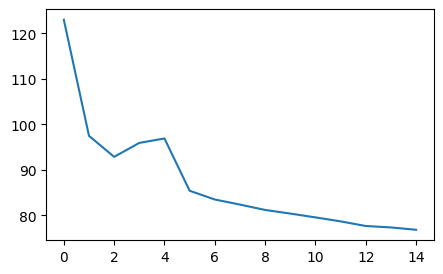

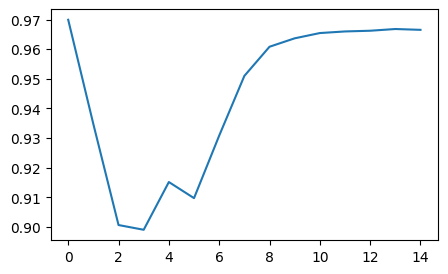

In [ ]:
# Обучим модель

history = cvaec.fit([images, labels, labels], # Обучающая выборка + метки классов для энкодера и декодера
         images,                              # Обучающая выборка
         epochs=EPOCHS,                            # Число эпох
         batch_size=BATCH_SIZE,                # Размер батча
         shuffle=True)                         # Обучающую выборку перемешиваем

# Отображение графиков обучения модели
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'])
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'])
plt.show()

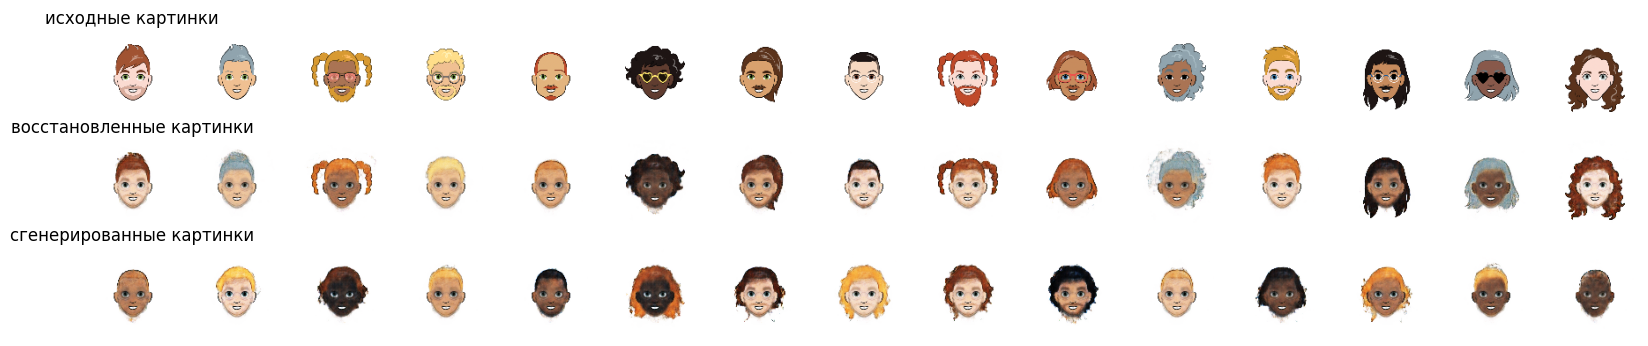

In [ ]:
# Эту ячейку можно перезапускать - получим разные варианты сгенерированных картинок в третьем ряду.

# Создадим набор 18 случайных меток (в пределах максимального значения каждой метки) для картинки
def random_labels():
  rnd_lb = []
  for i in range(len(df[2])):
    rnd_lb.append(random.randint(0, df[2][i]))
  return rnd_lb

num_images = 15 # число выводимых картинок

rnd_labels = []
lst_labels = []
lst_images = []

# генерим свои картинки на основе случайных созданных наборов меток и восстанавливаем исходные
random_latent_vectors = np.random.normal(size=(num_images, latent_dim))
for i in range(num_images):
  rnd_labels.append(random_labels())
  lst_images.append(images[i])
  lst_labels.append(labels[i])
rnd_labels = np.array(rnd_labels)
lst_labels = np.array(lst_labels)
lst_images = np.array(lst_images)
restored_images = cvaec.predict([lst_images, lst_labels, lst_labels],verbose=0)        # восстанавливаем исходные
generated_images = decoderCVAEC.predict([random_latent_vectors, rnd_labels],verbose=0) # генерим свои картинки

# Plot original and generated images
fig, axs = plt.subplots(3, num_images, figsize=(20, 4))
for i in range(num_images):
    axs[0,i].imshow(images[i])
    axs[0,i].axis('off')

    axs[1,i].imshow(restored_images[i])
    axs[1,i].axis('off')

    axs[2,i].imshow(generated_images[i])
    axs[2,i].axis('off')

axs[0,0].set_title('исходные картинки')
axs[1,0].set_title('восстановленные картинки')
axs[2,0].set_title('сгенерированные картинки')

plt.show()